# Navier Stokes Equation Reduced Basis Method 
Incompressible timedependet Navier Stokes equation

Find $(u,p):[0,T] \to (H_{0,D}^1)^d \times L^2$, s.t.

\begin{align}
\int_{\Omega} \partial_t u \cdot v + \int_{\Omega} \nu \nabla u \nabla v + u \cdot \nabla u v - \int_{\Omega} \operatorname{div}(v) p &= \int f v  && \forall v \in (H_{0,D}^1)^d, \\ 
- \int_{\Omega} \operatorname{div}(u) q &= 0 && \forall q \in L^2, \\
\quad u(t=0) & = u_0
\end{align}

In [1]:
from netgen import gui
from ngsolve import *
from netgen.geom2d import SplineGeometry
import scipy.sparse as sp
import numpy as np
from math import pi

In [2]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.08))
mesh.Curve(3)
Draw(mesh)
# viscosity
nu = 0.001
dt = 0.001

T = 1
dn = int(T/dt)
z = 20  # Number of snapshots

In [3]:
k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = FESpace([V,Q])

In [4]:
gfu_N = GridFunction(X)
gfu = GridFunction(X)
velocity = gfu.components[0]


uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))

Draw(gfu.components[0],mesh,"gfu",sd=3)

In [5]:
(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

In [6]:
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)

mstar += InnerProduct(u,v)*dx + dt*stokes

mstar.Assemble()

mh = BilinearForm(X)

mh += InnerProduct(u,v)*dx
mh.Assemble()

inv = mstar.mat.Inverse(X.FreeDofs())


conv = LinearForm(X)
conv += InnerProduct(grad(velocity)*velocity,v)*dx

In [7]:
rows,cols,vals = a.mat.COO()
Ah = sp.csr_matrix((vals,(rows,cols)))

rows,cols,vals = mh.mat.COO()
Mh = sp.csr_matrix((vals,(rows,cols)))

In [8]:
t = 0
len_h = len(gfu.components[0].vec)
erg_h = np.zeros([len(gfu.vec),int(dn)+1])
line = np.linspace(0,dn-1,z,dtype = int) # stors the number of linear distributed number of iteration from the solution
S_POD_v = np.zeros([len_h,z])
S_POD_p = np.zeros([len(gfu.components[1].vec),z])
#line = np.linspace(0,z,z) # stors the number of linear distributed number of iteration from the solution

$
M\bigg(\frac{u^{n+1}-u^n}{k}\bigg) + A u^{n+1} +C u^{n} = 0
$

$
M^*\bigg(u^{n+1}-u^n\bigg) = -k A u^n - k Cu^n
$

$
M^* = M + kA 
$

In [9]:
S_POD_v[:,0] = gfu.components[0].vec
S_POD_p[:,0] = gfu.components[1].vec
V_v = np.zeros([len(gfu.components[0].vec),z])
V_p = np.zeros([len(gfu.components[1].vec),z])
# implicit Euler/explicit Euler splitting method:
V_sb_v = MultiVector(gfu.components[0].vec, 1)
V_sb_v[0] = gfu.components[0].vec
V_v[:,0] = np.array(V_sb_v[0])/np.linalg.norm(np.array(V_sb_v[0]))

V_sb_p = MultiVector(gfu.components[1].vec, 1)
V_sb_p[0] = gfu.components[1].vec
V_p[:,0] = np.array(V_sb_p[0])/np.linalg.norm(np.array(V_sb_p[0]))

erg_h[:,0] = gfu.vec
o = 1
e = int(line[o])
for i in range(int(dn)):
    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res
    
    for r in line:
        if int(r) == i: #desided which solution will be orthogonalirsed
            if i > 0:
                with TaskManager():
                    V_sb_v.AppendOrthogonalize(gfu.components[0].vec)
                    V_sb_p.AppendOrthogonalize(gfu.components[1].vec)
                V_v[:,o] = np.array(V_sb_v[o])
                V_p[:,o] = np.array(V_sb_p[o])
                S_POD_v[:,o] = gfu.components[0].vec
                S_POD_p[:,o] = gfu.components[1].vec
                o = o + 1
    erg_h[:,i+1] = gfu.vec #stores the solution for comparing later
    t = t + dt
    Redraw()

In [ ]:
# implicit Euler/explicit Euler splitting method:
erg_h[:,0] = gfu.vec
S_POD_v[:,0] = gfu.components[0].vec
S_POD_p[:,0] = gfu.components[1].vec

o = 1
for i in range(int(dn)):
    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res
    
    for r in line:
        if int(r) == i: #desided which solution will be orthogonalirsed
            if i > 0:
                S_POD_v[:,o] = gfu.components[0].vec
                S_POD_p[:,o] = gfu.components[1].vec
                o = o + 1
    erg_h[:,i+1] = gfu.vec #stores the solution for comparing later
    t = t + dt
    Redraw()

In [ ]:
gfu.vec.FV().NumPy()[:] = erg_h[:,8000]
Draw(gfu.components[0],mesh,"gfu",sd=3)

## POD method
A other way to get the transforamtions matrix is the POD method.
gifen $\mathbb{S} = \{u_h^0,u_h^1,...u_h^{S-1}\}$ where $S$ ist the number of snapshots.

$
C = \mathbb{S}^T\mathbb{S}\\
$

$
C \in \mathbb{R}^{S \times S}
$

decompose the solution $u_h$ into the mean part $\bar{u}_h$ and the fluctuation part $\hat{u}_h$

$\bar{u}_h = \frac{1}{S} \sum_{n=0}^{S-1}u_h^n$  $\,\,\,\,\,\, \bar{u}_h \in \mathbb{R}^{Nh \times S-1}$????

and solve the eigenwalueproblem

$
C\Omega = \Omega\Lambda\\
\Lambda = diag[\lambda_0,...,\lambda_{S-1}], \Omega = [\omega^0,...,\omega^{S-1}]
$

$\lambda_i$ is the $i$th eigenvalue and $\omega^i$ is the corresponding normalized $i$th eigenvector

For a integer $r<<S$ given the $r$th POD basis like:

$
\phi_j = \frac{1}{\sqrt{\lambda_j}}\sum_{n=0}^{r-1}\omega^j_nu_h^n, \,\,\,\,\,\,\,\, j = 0,...,r-1
$

Frage:
For $j=0$  and $r = 3$ the expression becomes to:

$
\phi_0 = \frac{1}{\sqrt{\lambda_0}}\bigg[\omega_0^0 \cdot u_h^0 + \omega_1^0 \cdot u_h^1 +\omega_2^0 \cdot u_h^2\bigg]
$

So $\phi \in \mathbb{R}^{N_h\times r}$

To get a orthogonal basis $V = \{\phi_0,...\phi_{r-1}\}$

In [10]:
def calcMean(S_POD,len_h):
    ubar = np.zeros(len_h)
    #splitting the snapshotsolution like in the paper
    for i in range(S_POD.shape[1]):
        ubar = ubar + S_POD[:,i]                   
    ubar = 1/S_POD.shape[1] * ubar 
    for i in range(S_POD.shape[1]):
        S_POD[:,i] = S_POD[:,i] - ubar
    return S_POD,ubar

In [11]:
S_POD_v,ubar_v = calcMean(S_POD_v,len(gfu.components[0].vec))
S_POD_p,ubar_p = calcMean(S_POD_p,len(gfu.components[1].vec))

# POD_Method RedBasis Book

In [ ]:
def calcPOD(S_POD,r):
    C = np.transpose(S_POD).dot(S_POD)
    V_POD = np.zeros([S_POD.shape[0],r])
    U,Sig,VH = np.linalg.svd(C)
    VH = np.transpose(VH)
    line = np.linspace(0,S_POD.shape[1]-1,r,dtype = int)
    o = 0
    for i in line:
        V_POD[:,o] = 1/(np.sqrt(Sig[i])) * S_POD.dot(VH[:,i])
        o = o + 1
    
    return V_POD

In [ ]:
r = 6
V_POD_v = calcPOD(S_POD_v,r)
V_POD_p = calcPOD(S_POD_p,r)

# POD_Method paper

In [12]:
def calcPODp(S_POD,r):
    C = np.transpose(S_POD).dot(S_POD)
    lam,omg = np.linalg.eigh(C)
    lam = np.abs(lam)
    V_POD = np.zeros([S_POD.shape[0],r])
    for i in range(r):
        for j in range(r):
            V_POD[:,i] += omg[j,i]*S_POD[:,j]
        V_POD[:,i] = 1/np.sqrt(lam[i]) * V_POD[:,i]
    return V_POD

In [13]:
r = z
V_POD_v = calcPODp(S_POD_v,r)
V_POD_p = calcPODp(S_POD_p,r)

# Offline decomposition

$C_h(\omega,u,v) = \int_K(\nabla \omega \cdot u): v$

$C0_j = C_h(\bar{u}_h,\bar{u}_h,\phi_j)$

$C1_{i,j} = C_h(\bar{u}_h,\phi_i,\phi_j) + C_h(\phi_i,\bar{u}_h,\phi_j)$

$C_{i,j,k} = C_h(\phi_i,\phi_j,\phi_k)$

In [14]:
def Ch_ngsolve(wh,uh,vh):
    with TaskManager():
        u_N = GridFunction(V)
        v_N = GridFunction(V)
        w_N = GridFunction(V)
        w_N.vec.FV().NumPy()[:] = wh
        u_N.vec.FV().NumPy()[:] = uh
        v_N.vec.FV().NumPy()[:] = vh
        Ch = Integrate(InnerProduct(w_N,Grad(u_N)*v_N),mesh)
    
    return Ch

In [15]:
#r = z
V_POD_v = V_v
V_POD_p = V_p
C0 = np.zeros(r)
w = ubar_v
for i in range(r):
    #v = V_POD_v[:,i]
    #w = S_POD_v[:,i]
    v = V_v[:,i]
    C0[i] = Ch_ngsolve(w,w,v)
C0

array([ 1.24448621e-06, -3.98628365e-05, -4.33934691e-05,  6.78300796e-06,
        6.34403105e-08, -4.14546040e-07, -5.90723186e-05, -8.44774133e-06,
        6.14971314e-06, -2.80986170e-05, -1.77425575e-05, -3.83082575e-06,
        5.40049903e-06, -1.79028801e-05, -5.16552914e-06,  2.48783636e-05,
        9.03174252e-06,  1.03688920e-05,  3.77258206e-05,  1.52100817e-05])

In [16]:
C1 = np.zeros([r,r])
for i in range(r):
    w = ubar_v
    #w = S_POD_v[:,i]
    u = V_POD_v[:,i]
    for j in range(r):
        v = V_POD_v[:,j]
        C1[i,j] = Ch_ngsolve(w,u,v)
        C1[i,j] += Ch_ngsolve(u,w,v)
C1

array([[-4.32542243e-08, -1.48557288e-06, -2.16796669e-06,
         7.25263498e-07, -2.71957773e-07, -1.08509086e-06,
        -2.46434504e-06,  7.58890916e-07,  1.67087288e-06,
        -1.78649187e-06, -5.65094404e-07,  1.53102374e-06,
         1.68999031e-06,  1.76794736e-07,  1.61059872e-06,
         2.14056167e-06,  3.88858890e-07,  1.97851961e-06,
         2.30440731e-06,  1.88994898e-06],
       [ 2.09762362e-08, -3.87703860e-07, -1.35569206e-06,
         1.89931716e-07, -2.77083055e-07,  5.13443531e-07,
         2.42143393e-08, -2.49450159e-07, -4.51421174e-08,
         2.31118510e-07,  4.03412410e-08, -1.97008443e-07,
        -1.50821837e-07, -1.42234754e-07, -2.16621963e-07,
         4.01813131e-08,  6.86700220e-08, -1.95637305e-07,
        -4.55183344e-09, -1.87967259e-07],
       [ 7.95006386e-08, -7.28968003e-07,  4.56141071e-07,
        -1.94244058e-06,  2.35755296e-07,  8.12057114e-07,
         2.39474017e-07, -5.20871393e-07, -6.20722283e-07,
        -2.09365107e-07, -1.4

In [17]:
C = np.zeros([r,r,r])
for i in range(r):
    print(i)
    w = V_POD_v[:,i]
    #w = S_POD_v[:,i]
    for j in range(r):
        u = V_POD_v[:,j]
        #u = S_POD_v[:,j]
        for k in range(r):
            v = V_POD_v[:,k]
            C[i,j,k] = Ch_ngsolve(u,w,v)
C

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


array([[[-1.41293694e-09,  2.54757002e-09, -2.68783709e-08, ...,
          6.57755830e-09,  3.30208641e-10,  1.06926298e-08],
        [-1.68513516e-05,  1.23341625e-06,  1.12834113e-06, ...,
          3.82502525e-08,  1.61790689e-07,  1.06787901e-07],
        [ 4.51514464e-07,  4.03734400e-06,  6.07970916e-07, ...,
         -2.34299154e-07, -1.48042280e-07, -2.09927810e-07],
        ...,
        [ 2.64095403e-07,  1.08548807e-07,  8.27925586e-08, ...,
          1.11013604e-06, -7.03959124e-07, -1.46357311e-06],
        [ 4.16001142e-07,  2.05118706e-08, -2.16972160e-08, ...,
          1.66057359e-06,  8.71698263e-07, -9.30933608e-07],
        [ 7.34978398e-07, -6.70007645e-10, -1.17086698e-07, ...,
          9.67261002e-07,  1.61061594e-06,  7.46868328e-07]],

       [[ 1.68530845e-05, -1.24499899e-06, -1.16298127e-06, ...,
         -2.95798882e-08, -1.57061162e-07, -1.04304737e-07],
        [-7.29673443e-10, -2.22507706e-09, -8.80656692e-09, ...,
         -1.69962850e-09, -6.41846352e

In [18]:
V_POD = np.zeros([len(gfu.vec),r])
V_POD[0:len(gfu.components[0].vec),0:r] = V_POD_v
V_POD[len(gfu.components[0].vec):len(gfu.vec),0:r] = V_POD_p
#V_POD = 1/(np.sqrt(2))*V_POD


# RedBasis NavierStokes

In [19]:
MN = np.transpose(V_POD).dot(Mh.dot(V_POD))
AN = np.transpose(V_POD).dot(Ah.dot(V_POD))

In [20]:
gfu_N = GridFunction(X)
gfu = GridFunction(X)
gfu_N.vec.FV().NumPy()[:] = erg_h[:,0]
gfu.vec.FV().NumPy()[:] = erg_h[:,0]

uN = np.array(gfu_N.vec).dot(V_POD)
Draw(gfu.components[0],mesh,"gfu",sd=3)
Draw(gfu_N.components[0],mesh,"gfu_N",sd=3)
Draw(gfu_N.components[0]-gfu.components[0],mesh,"error",sd=3)
err = res.CreateVector()
fom = res.CreateVector()
rom = res.CreateVector()

In [21]:
#dt = 0.0001
#dn = 1/dt
FOM_L2_norm = []
ROM_L2_norm = []
Residium = []
time = []
erg_N = np.zeros([len(gfu.vec),int(dn)+1])
erg_N[:,0] = gfu_N.vec


MN_star = MN + dt*AN
inv_N = np.linalg.inv(MN_star)
for i in range(int(dn)):
    err.vec = sqrt (Integrate ((gfu.components[0]-gfu_N.components[0])*(gfu.components[0]-gfu_N.components[0]),mesh))
    fom.vec = Integrate ((gfu.components[0])*(gfu.components[0]),mesh)
    rom.vec = Integrate ((gfu_N.components[0])*(gfu_N.components[0]),mesh)
    res_N = AN.dot(uN) + uN.dot(C.dot(uN)) + C1.dot(uN) 
    uN -= dt * inv_N.dot(res_N)
    erg_N[:,i+1] = (uN).dot(np.transpose(V_POD))
    
    
    gfu.vec.FV().NumPy()[:] = erg_h[:,i+1]
    gfu_N.vec.FV().NumPy()[:] = (uN).dot(np.transpose(V_POD))
    Residium.append(err.vec)
    FOM_L2_norm.append(fom.vec)
    ROM_L2_norm.append(rom.vec)
    time.append(dt*i)
    Redraw()

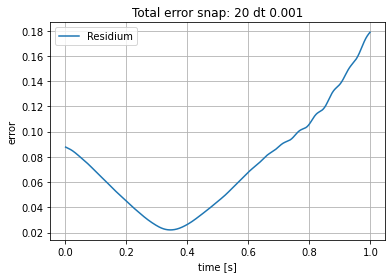

In [22]:
import matplotlib.pyplot as plt
plt.title("Total error snap: {} dt {}".format(z,dt))
plt.ylabel("error")
plt.xlabel("time [s]")
plt.grid()
plt.plot(time[1:],Residium[1:], label='Residium')
plt.legend()
plt.savefig("plots_Tensor/Total error {} dt GM wechsel".format(z))

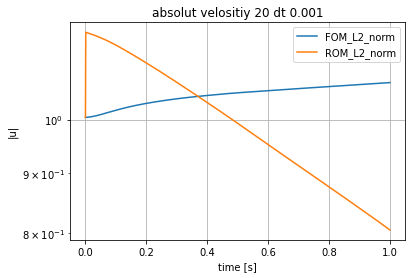

In [23]:
plt.title("absolut velositiy {} dt {}".format(z,dt))
plt.ylabel("|u|")
plt.xlabel("time [s]")
plt.grid()
plt.semilogy(time,FOM_L2_norm, label='FOM_L2_norm')
plt.semilogy(time,ROM_L2_norm, label='ROM_L2_norm')
plt.legend()
plt.savefig("plots/absolut velositiy {}".format(z))

In [24]:
FOM_L2_norm = []
ROM_L2_norm = []
Residium_N = []
for i in range(int(dn)):
    sum_h = sum(erg_h[:,i])
    sum_N = sum(erg_N[:,i])
    FOM_L2_norm.append(np.abs(sum_h*sum_h))
    ROM_L2_norm.append(np.abs(sum_N*sum_h))
    red = sum_N-sum_h
    Residium_N.append(np.sqrt(np.abs(red*red)))

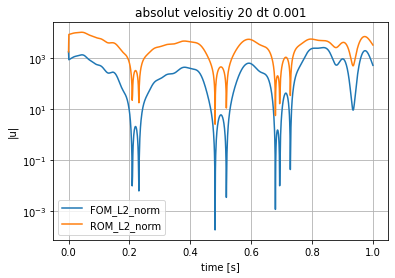

In [25]:
plt.title("absolut velositiy {} dt {}".format(z,dt))
plt.ylabel("|u|")
plt.xlabel("time [s]")
plt.grid()
plt.semilogy(time,FOM_L2_norm, label='FOM_L2_norm')
plt.semilogy(time,ROM_L2_norm, label='ROM_L2_norm')
plt.legend()
plt.savefig("plots/absolut velositiy {}".format(z))

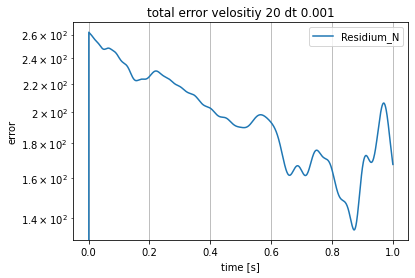

In [28]:
plt.title("total error velositiy {} dt {}".format(z,dt))
plt.ylabel("error")
plt.xlabel("time [s]")
plt.grid()
plt.semilogy(time,Residium_N, label='Residium_N')
plt.legend()
plt.savefig("plots/total error velositiy {}".format(z))

In [ ]:
np.linalg.norm(Residium)

In [ ]:
gfu.vec.FV().NumPy()[:] = erg_h[:,500]
gfu_N.vec.FV().NumPy()[:] = erg_N[:,495]
Draw(gfu.components[0],mesh,"gfu",sd=3)
Draw(gfu_N.components[0],mesh,"gfu_N",sd=3)